In [8]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install progressbar2

Note: you may need to restart the kernel to use updated packages.


In [10]:
from torch import nn
from collections import OrderedDict
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
import torchvision
import random
from torch.utils.data import Subset
from matplotlib import pyplot as plt
from torchsummary import summary
from torchvision import transforms
import progressbar as pb
import numpy as np

SUM = lambda x,y : x+y

def check_equity(property,a,b):
    pa = getattr(a,property)
    pb = getattr(b,property)
    assert  pa==pb, "Different {}: {}!={}".format(property,pa,pb)

    return pa

def module_unwrap(mod:nn.Module,recursive=False):
    children = OrderedDict()
    try:
        for name, module in mod.named_children():
            if (recursive):
                recursive_call = module_unwrap(module,recursive=True)
                if (len(recursive_call)>0):
                    for k,v in recursive_call.items():
                        children[name+"_"+k] = v
                else:
                    children[name] = module
            else:
                children[name] = module
    except AttributeError:
        pass

    return children

class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels,batch_norm=False):

        super().__init__()

        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1
                        }

        noop = lambda x : x

        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels , **conv2_params)
        #self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        self.bn1 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, **conv2_params)
        #self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        self.bn2 = nn.GroupNorm(32, out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x

class Classifier(nn.Module):

    def __init__(self,num_classes=10):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self,x):

        return self.classifier(x)

class VGG16(nn.Module):

  def __init__(self, input_size, batch_norm=False):
    super(VGG16, self).__init__()

    self.in_channels,self.in_width,self.in_height = input_size

    self.block_1 = VGGBlock(self.in_channels,64,batch_norm=batch_norm)
    self.block_2 = VGGBlock(64, 128,batch_norm=batch_norm)
    self.block_3 = VGGBlock(128, 256,batch_norm=batch_norm)
    self.block_4 = VGGBlock(256,512,batch_norm=batch_norm)


  @property
  def input_size(self):
      return self.in_channels,self.in_width,self.in_height

  def forward(self, x):

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    # x = self.avgpool(x)
    x = torch.flatten(x,1)

    return x

class CombinedLoss(nn.Module):
    def __init__(self, loss_a, loss_b, loss_combo, _lambda=1.0):
        super().__init__()
        self.loss_a = loss_a
        self.loss_b = loss_b
        self.loss_combo = loss_combo

        self.register_buffer('_lambda',torch.tensor(float(_lambda),dtype=torch.float32))


    def forward(self,y_hat,y):

        return self.loss_a(y_hat[0],y[0]) + self.loss_b(y_hat[1],y[1]) + self._lambda * self.loss_combo(y_hat[2],torch.cat(y,0))

DO='TRAIN'

random.seed(47)

combo_fn = SUM

lambda_reg = 1

def test(net,classifier, loader):

      net.to(dev)
      classifier.to(dev)

      net.eval()

      sum_accuracy = 0

      # Process each batch
      for j, (input, labels) in enumerate(loader):

        input = input.to(dev)
        labels = labels.float().to(dev)

        features = net(input)

        pred = torch.squeeze(classifier(features))

        # https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293/ 2
        #pred_labels = (pred >= 0.0).long()  # Binarize predictions to 0 and 1
        _,pred_label = torch.max(pred, dim = 1)
        pred_labels = (pred_label == labels).float()

        batch_accuracy = pred_labels.sum().item() / len(labels)

        # Update accuracy
        sum_accuracy += batch_accuracy

      epoch_accuracy = sum_accuracy / len(loader)
      return epoch_accuracy
      #print(f"Accuracy test: {epoch_accuracy:0.5}")

def train(nets, loaders, optimizer, criterion, epochs=20, dev=None, save_param=False, model_name="valerio"):
    # try:
      nets = [n.to(dev) for n in nets]

      model_a = module_unwrap(nets[0], True)
      model_b = module_unwrap(nets[1], True)
      model_c = module_unwrap(nets[2], True)

      reg_loss = nn.MSELoss()

      criterion.to(dev)
      reg_loss.to(dev)

      # Initialize history
      history_loss = {"train": [], "val": [], "test": []}
      history_accuracy = {"train": [], "val": [], "test": []}
      history_test = []
      # Store the best val accuracy
      best_val_accuracy = 0

      # Process each epoch
      for epoch in range(epochs):
        # Initialize epoch variables
        sum_loss = {"train": 0, "val": 0, "test": 0}
        sum_accuracy = {"train": [0,0,0], "val": [0,0,0], "test": [0,0,0]}

        progbar = None
        # Process each split
        for split in ["train", "val", "test"]:
          if split == "train":
            for n in nets:
              n.train()
            widgets = [
              ' [', pb.Timer(), '] ',
              pb.Bar(),
              ' [', pb.ETA(), '] ', pb.Variable('ta','[Train Acc: {formatted_value}]')
            ]

            progbar = pb.ProgressBar(max_value=len(loaders[split][0]),widgets=widgets,redirect_stdout=True)

          else:
            for n in nets:
              n.eval()
          # Process each batch
          for j,((input_a, labels_a),(input_b, labels_b)) in enumerate(zip(loaders[split][0],loaders[split][1])):

            input_a = input_a.to(dev)
            input_b = input_b.to(dev)

            labels_a = labels_a.long().to(dev)
            labels_b = labels_b.long().to(dev)
            #print(labels_a.shape)
            #labels_a = labels_a.squeeze()
            #labels_b = labels_b.squeeze()
            
            #labels_a = labels_a.unsqueeze(1)
            #labels_b = labels_b.unsqueeze(1)
            #print(labels_a.shape)
            #labels_a = labels_a.argmax(-1)
            #labels_b = labels_b.argmax(-1)

            inputs = torch.cat([input_a,input_b],axis=0)
            labels = torch.cat([labels_a, labels_b])

            #labels  = labels.squeeze()
            #print(labels.shape)
            #labels = labels.argmax(-1)

            # Reset gradients
            optimizer.zero_grad()
            # Compute output
            features_a = nets[0](input_a)
            features_b = nets[1](input_b)
            features_c = nets[2](inputs)

            pred_a = torch.squeeze(nets[3](features_a))
            pred_b = torch.squeeze(nets[3](features_b))
            pred_c = torch.squeeze(nets[3](features_c))

            loss = criterion(pred_a, labels_a) + criterion(pred_b, labels_b) + criterion(pred_c, labels)

            for n in model_a:
              layer_a = model_a[n]
              layer_b = model_b[n]
              layer_c = model_c[n]
              if (isinstance(layer_a,nn.Conv2d)):
                loss += lambda_reg * reg_loss(combo_fn(layer_a.weight,layer_b.weight),layer_c.weight)
                if (layer_a.bias is not None):
                  loss += lambda_reg * reg_loss(combo_fn(layer_a.bias, layer_b.bias), layer_c.bias)

            # Update loss
            sum_loss[split] += loss.item()
            # Check parameter update
            if split == "train":
              # Compute gradients
              loss.backward()
              # Optimize
              optimizer.step()

            # Compute accuracy

            #https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293/ 2
            #pred_labels_a = (pred_a >= 0.0).long()  # Binarize predictions to 0 and 1
            #pred_labels_b = (pred_b >= 0.0).long()  # Binarize predictions to 0 and 1
            #pred_labels_c = (pred_c >= 0.0).long()  # Binarize predictions to 0 and 1

            #print(pred_a.shape)

            _,pred_label_a = torch.max(pred_a, dim = 1)
            pred_labels_a = (pred_label_a == labels_a).float()

            _,pred_label_b = torch.max(pred_b, dim = 1)
            pred_labels_b = (pred_label_b == labels_b).float()

            _,pred_label_c = torch.max(pred_c, dim = 1)
            pred_labels_c = (pred_label_c == labels).float()

            batch_accuracy_a = pred_labels_a.sum().item() / len(labels_a)
            batch_accuracy_b = pred_labels_b.sum().item() / len(labels_b)
            batch_accuracy_c = pred_labels_c.sum().item() / len(labels)

            # Update accuracy
            sum_accuracy[split][0] += batch_accuracy_a
            sum_accuracy[split][1] += batch_accuracy_b
            sum_accuracy[split][2] += batch_accuracy_c


            if (split=='train'):
              progbar.update(j, ta=batch_accuracy_c)

        if (progbar is not None):
          progbar.finish()
        # Compute epoch loss/accuracy
        epoch_loss = {split: sum_loss[split] / len(loaders[split][0]) for split in ["train", "val", "test"]}
        epoch_accuracy = {split: [sum_accuracy[split][i] / len(loaders[split][0]) for i in range(len(sum_accuracy[split])) ] for split in ["train", "val", "test"]}

        # # Store params at the best validation accuracy
        # if save_param and epoch_accuracy["val"] > best_val_accuracy:
        #   # torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
        #   torch.save(net.state_dict(), f"{model_name}_best_val.pth")
        #   best_val_accuracy = epoch_accuracy["val"]

        print(f"Epoch {epoch + 1}:")
        # Update history
        for split in ["train", "val", "test"]:
          history_loss[split].append(epoch_loss[split])
          history_accuracy[split].append(epoch_accuracy[split])
          # Print info
          print(f"\t{split}\tLoss: {epoch_loss[split]:0.5}\tVGG 1:{epoch_accuracy[split][0]:0.5}"
                f"\tVGG 2:{epoch_accuracy[split][1]:0.5}\tVGG *:{epoch_accuracy[split][2]:0.5}")

        if save_param:
          torch.save({'vgg_a':nets[0].state_dict(),'vgg_b':nets[1].state_dict(),'vgg_star':nets[2].state_dict(),'classifier':nets[3].state_dict()},f'{model_name}.pth')


        
        print(f"Accuracy test VGGA: {test(nets[0], nets[3], test_loader_all):0.5}")
        print(f"Accuracy test VGGB: {test(nets[1], nets[3], test_loader_all):0.5}")
        print(f"Accuracy test VGG*: {test(nets[2], nets[3], test_loader_all):0.5}")
 
        summed_state_dict = OrderedDict()
 
        for key in nets[2].state_dict():
          if key.find('conv') >=0:
            #print(key)
            summed_state_dict[key] = combo_fn(nets[0].state_dict()[key],nets[1].state_dict()[key])
          else:
            summed_state_dict[key] = nets[2].state_dict()[key]
 
        nets[2].load_state_dict(summed_state_dict)
        accuracy_star = test(nets[2], nets[3], test_loader_all)
        print(f"Accuracy test VGGSTAR: {accuracy_star:0.5}")
        history_test.append(accuracy_star)


      # Plot accuracy
      plt.title("Accuracy VGGSTAR over epochs")
      plt.plot(history_test)
      #plt.legend()
      plt.show()


In [11]:
root_dir = './'

rescale_data = transforms.Lambda(lambda x : x/255)

# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  rescale_data,
  #transforms.Normalize((-0.7376), (0.5795))
])

test_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  rescale_data,
  #transforms.Normalize((0.1327), (0.2919))
])

# Load MNIST dataset with transforms
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=data_transform)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=test_transform)

# Dataset len
num_train = len(train_set)
num_test = len(test_set)
print(f"Num. training samples: {num_train}")
print(f"Num. test samples:     {num_test}")

train_idx = np.random.permutation(np.arange(len(train_set)))
test_idx = np.arange(len(test_set))

# Fraction of the original train set that we want to use as validation set
val_frac = 0.1
# Number of samples of the validation set
num_val = int(num_train * val_frac) 
num_train = num_train - num_val

# Split training set
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as val set")
print(f"{len(test_set)} samples used as test set")

val_set_a = Subset(train_set, val_idx)
train_set_a = Subset(train_set, train_idx)
test_set_a = test_set

# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize((32,32)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

# Compose transformations
test_transform = transforms.Compose([
  transforms.Resize((32,32)),
  transforms.Grayscale(num_output_channels=1),
  transforms.ToTensor(),
])

Using downloaded and verified file: ./MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw
Using downloaded and verified file: ./MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw
Using downloaded and verified file: ./MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
Num. training samples: 60000
Num. test samples:     10000
54000 samples used as train set
6000  samples used as val set
10000 samples used as test set


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [12]:
base_dir = 'http://ufldl.stanford.edu/housenumbers/'
train_set_svhn = torchvision.datasets.SVHN(root=base_dir, split='train', download=True, transform=data_transform, target_transform=None)
test_set_svhn = torchvision.datasets.SVHN(root=base_dir, split='test', download=True, transform=test_transform)

num_train_svhn = len(train_set_svhn)
num_test_svhn = len(test_set_svhn)
print(f"Num. training samples: {num_train_svhn}")
print(f"Num. test samples:     {num_test_svhn}")

# List of indexes on the training set
train_idx_svhn = list(range(num_train_svhn))

# List of indexes of the test set
test_idx_svhn = list(range(num_test_svhn))

# Shuffle the training set
import random

random.shuffle(train_idx_svhn)
for i in range(10):
  print(train_idx_svhn[i])

# Fraction of the original train set that we want to use as validation set
val_frac = 0.1
# Number of samples of the validation set
num_val = int(num_train_svhn * val_frac) 
num_train = num_train_svhn - num_val

# Split training set
val_idx_svhn = train_idx_svhn[num_train:]
train_idx_svhn = train_idx_svhn[:num_train]

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as val set")

val_set_b = Subset(train_set_svhn, val_idx_svhn)
train_set_b = Subset(train_set_svhn, train_idx_svhn)
test_set_b = test_set_svhn

test_set = torch.utils.data.ConcatDataset([test_set_a, test_set_b])

# Define loaders

train_loader_a = DataLoader(train_set_a, batch_size=128, num_workers=0, shuffle=True, drop_last=True)
val_loader_a   = DataLoader(val_set_a,   batch_size=128, num_workers=0, shuffle=False, drop_last=False)
test_loader_a  = DataLoader(test_set_a,  batch_size=128, num_workers=0, shuffle=False, drop_last=False)

train_loader_b = DataLoader(train_set_b, batch_size=128, num_workers=0, shuffle=True, drop_last=True)
val_loader_b   = DataLoader(val_set_b,   batch_size=128, num_workers=0, shuffle=False, drop_last=False)
test_loader_b  = DataLoader(test_set_b,  batch_size=128, num_workers=0, shuffle=False, drop_last=False)

test_loader_all = DataLoader(test_set,batch_size=128, num_workers=0,shuffle=False,drop_last=False)


# Define dictionary of loaders
loaders = {"train": [train_loader_a,train_loader_b],
           "val":   [val_loader_a,val_loader_b],
           "test":  [test_loader_a,test_loader_b]}

Using downloaded and verified file: http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Using downloaded and verified file: http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Num. training samples: 73257
Num. test samples:     26032
32553
61316
44598
62771
49643
55735
33610
29224
47794
11023
65932 samples used as train set
7325  samples used as val set


In [13]:
model1 = VGG16((1,32,32),batch_norm=True)
model2 = VGG16((1,32,32),batch_norm=True)
model3 = VGG16((1,32,32),batch_norm=True)
classifier = Classifier(num_classes=10)

nets = [model1,model2,model3,classifier]

dev = torch.device('cuda')

parameters = set()

for n in nets:
  parameters |= set(n.parameters())

optimizer = torch.optim.SGD(parameters, lr = 0.01)
# Define a loss
#criterion = nn.BCEWithLogitsLoss()#,nn.BCEWithLogitsLoss(),nn.BCEWithLogitsLoss(),_lambda = 1)
criterion = nn.CrossEntropyLoss()
n_params = 0

 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.332]


Epoch 1:
	train	Loss: 6.331	VGG 1:0.2323	VGG 2:0.34572	VGG *:0.21033
	val	Loss: 4.6535	VGG 1:0.40813	VGG 2:0.64046	VGG *:0.41908
	test	Loss: 4.6464	VGG 1:0.40368	VGG 2:0.634	VGG *:0.41772
Accuracy test VGGA: 0.20892
Accuracy test VGGB: 0.49155
Accuracy test VGG*: 0.45595
Accuracy test VGGSTAR: 0.17387


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.742]


Epoch 2:
	train	Loss: 3.2822	VGG 1:0.62992	VGG 2:0.71166	VGG *:0.54493
	val	Loss: 1.9114	VGG 1:0.80794	VGG 2:0.82081	VGG *:0.73528
	test	Loss: 1.8754	VGG 1:0.81655	VGG 2:0.81507	VGG *:0.75579
Accuracy test VGGA: 0.37032
Accuracy test VGGB: 0.61971
Accuracy test VGG*: 0.69988
Accuracy test VGGSTAR: 0.32319


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.766]


Epoch 3:
	train	Loss: 2.0149	VGG 1:0.86578	VGG 2:0.82117	VGG *:0.65021
	val	Loss: 1.2951	VGG 1:0.92337	VGG 2:0.86486	VGG *:0.79982
	test	Loss: 1.3135	VGG 1:0.92741	VGG 2:0.85502	VGG *:0.80921
Accuracy test VGGA: 0.42362
Accuracy test VGGB: 0.65802
Accuracy test VGG*: 0.75961
Accuracy test VGGSTAR: 0.41085


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.809]


Epoch 4:
	train	Loss: 1.6935	VGG 1:0.87912	VGG 2:0.85941	VGG *:0.71709
	val	Loss: 1.0699	VGG 1:0.95213	VGG 2:0.88098	VGG *:0.82995
	test	Loss: 1.1073	VGG 1:0.95164	VGG 2:0.8665	VGG *:0.8338
Accuracy test VGGA: 0.44179
Accuracy test VGGB: 0.69828
Accuracy test VGG*: 0.78701
Accuracy test VGGSTAR: 0.39711


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.852]


Epoch 5:
	train	Loss: 1.4088	VGG 1:0.94453	VGG 2:0.88092	VGG *:0.72236
	val	Loss: 0.99043	VGG 1:0.95887	VGG 2:0.88664	VGG *:0.83655
	test	Loss: 1.0407	VGG 1:0.95461	VGG 2:0.87757	VGG *:0.83533
Accuracy test VGGA: 0.44312
Accuracy test VGGB: 0.73595
Accuracy test VGG*: 0.78765
Accuracy test VGGSTAR: 0.39395


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.812]


Epoch 6:
	train	Loss: 1.2277	VGG 1:0.95943	VGG 2:0.89532	VGG *:0.75658
	val	Loss: 0.91114	VGG 1:0.96728	VGG 2:0.90492	VGG *:0.84528
	test	Loss: 0.91359	VGG 1:0.96895	VGG 2:0.9014	VGG *:0.84641
Accuracy test VGGA: 0.45387
Accuracy test VGGB: 0.76826
Accuracy test VGG*: 0.7969
Accuracy test VGGSTAR: 0.36264


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.805]


Epoch 7:
	train	Loss: 1.4487	VGG 1:0.91291	VGG 2:0.90645	VGG *:0.71834
	val	Loss: 0.91427	VGG 1:0.96296	VGG 2:0.90658	VGG *:0.84386
	test	Loss: 0.9385	VGG 1:0.96282	VGG 2:0.89666	VGG *:0.84919
Accuracy test VGGA: 0.46878
Accuracy test VGGB: 0.74238
Accuracy test VGG*: 0.80206
Accuracy test VGGSTAR: 0.32405


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.852]


Epoch 8:
	train	Loss: 1.1165	VGG 1:0.96253	VGG 2:0.9128	VGG *:0.77052
	val	Loss: 0.82332	VGG 1:0.97262	VGG 2:0.91439	VGG *:0.85551
	test	Loss: 0.84135	VGG 1:0.97379	VGG 2:0.90724	VGG *:0.85914
Accuracy test VGGA: 0.47961
Accuracy test VGGB: 0.72418
Accuracy test VGG*: 0.81242
Accuracy test VGGSTAR: 0.46426


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.852]


Epoch 9:
	train	Loss: 1.0521	VGG 1:0.97009	VGG 2:0.92254	VGG *:0.77668
	val	Loss: 0.80545	VGG 1:0.97561	VGG 2:0.91157	VGG *:0.86042
	test	Loss: 0.82893	VGG 1:0.97696	VGG 2:0.90477	VGG *:0.859
Accuracy test VGGA: 0.48798
Accuracy test VGGB: 0.70493
Accuracy test VGG*: 0.81372
Accuracy test VGGSTAR: 0.43617


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.836]


Epoch 10:
	train	Loss: 0.97838	VGG 1:0.97474	VGG 2:0.92872	VGG *:0.7874
	val	Loss: 0.80028	VGG 1:0.98084	VGG 2:0.91041	VGG *:0.85622
	test	Loss: 0.82645	VGG 1:0.98101	VGG 2:0.89992	VGG *:0.86256
Accuracy test VGGA: 0.4885
Accuracy test VGGB: 0.73751
Accuracy test VGG*: 0.81649
Accuracy test VGGSTAR: 0.34259


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:   0.84]


Epoch 11:
	train	Loss: 0.93773	VGG 1:0.97834	VGG 2:0.93158	VGG *:0.79442
	val	Loss: 0.80904	VGG 1:0.97965	VGG 2:0.91772	VGG *:0.85057
	test	Loss: 0.83632	VGG 1:0.98062	VGG 2:0.91001	VGG *:0.84828
Accuracy test VGGA: 0.49224
Accuracy test VGGB: 0.70376
Accuracy test VGG*: 0.80289
Accuracy test VGGSTAR: 0.48338


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.879]


Epoch 12:
	train	Loss: 0.88097	VGG 1:0.97961	VGG 2:0.93592	VGG *:0.80674
	val	Loss: 0.74909	VGG 1:0.98452	VGG 2:0.91689	VGG *:0.87017
	test	Loss: 0.78694	VGG 1:0.97903	VGG 2:0.90912	VGG *:0.86579
Accuracy test VGGA: 0.51177
Accuracy test VGGB: 0.74
Accuracy test VGG*: 0.82477
Accuracy test VGGSTAR: 0.37483


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.867]


Epoch 13:
	train	Loss: 0.85111	VGG 1:0.98172	VGG 2:0.94038	VGG *:0.81121
	val	Loss: 0.76711	VGG 1:0.97967	VGG 2:0.92104	VGG *:0.86143
	test	Loss: 0.77068	VGG 1:0.98131	VGG 2:0.91901	VGG *:0.85828
Accuracy test VGGA: 0.49291
Accuracy test VGGB: 0.69664
Accuracy test VGG*: 0.81026
Accuracy test VGGSTAR: 0.52671


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.852]


Epoch 14:
	train	Loss: 0.81856	VGG 1:0.98369	VGG 2:0.94592	VGG *:0.8128
	val	Loss: 0.71577	VGG 1:0.98305	VGG 2:0.91888	VGG *:0.87622
	test	Loss: 0.71781	VGG 1:0.98428	VGG 2:0.92029	VGG *:0.87859
Accuracy test VGGA: 0.50615
Accuracy test VGGB: 0.70637
Accuracy test VGG*: 0.83591
Accuracy test VGGSTAR: 0.48199


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.871]


Epoch 15:
	train	Loss: 0.95455	VGG 1:0.98597	VGG 2:0.94873	VGG *:0.76408
	val	Loss: 0.74644	VGG 1:0.98518	VGG 2:0.91922	VGG *:0.8676
	test	Loss: 0.76908	VGG 1:0.98507	VGG 2:0.9198	VGG *:0.8655
Accuracy test VGGA: 0.52022
Accuracy test VGGB: 0.76898
Accuracy test VGG*: 0.81918
Accuracy test VGGSTAR: 0.48654


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.863]


Epoch 16:
	train	Loss: 0.7677	VGG 1:0.98658	VGG 2:0.95275	VGG *:0.81903
	val	Loss: 0.71036	VGG 1:0.98416	VGG 2:0.92304	VGG *:0.87604
	test	Loss: 0.709	VGG 1:0.98705	VGG 2:0.92257	VGG *:0.87505
Accuracy test VGGA: 0.51859
Accuracy test VGGB: 0.76394
Accuracy test VGG*: 0.83477
Accuracy test VGGSTAR: 0.50269


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.848]


Epoch 17:
	train	Loss: 0.77986	VGG 1:0.98825	VGG 2:0.95543	VGG *:0.81127
	val	Loss: 0.70455	VGG 1:0.98554	VGG 2:0.9237	VGG *:0.87583
	test	Loss: 0.73419	VGG 1:0.98467	VGG 2:0.91653	VGG *:0.87574
Accuracy test VGGA: 0.51903
Accuracy test VGGB: 0.76075
Accuracy test VGG*: 0.8348
Accuracy test VGGSTAR: 0.52909


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.906]


Epoch 18:
	train	Loss: 0.76787	VGG 1:0.98872	VGG 2:0.9565	VGG *:0.81412
	val	Loss: 0.75841	VGG 1:0.98485	VGG 2:0.91539	VGG *:0.87216
	test	Loss: 0.78924	VGG 1:0.98329	VGG 2:0.90892	VGG *:0.87348
Accuracy test VGGA: 0.51967
Accuracy test VGGB: 0.71955
Accuracy test VGG*: 0.83026
Accuracy test VGGSTAR: 0.52496


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.875]


Epoch 19:
	train	Loss: 0.74665	VGG 1:0.98966	VGG 2:0.9606	VGG *:0.81449
	val	Loss: 0.74148	VGG 1:0.98687	VGG 2:0.92005	VGG *:0.86867
	test	Loss: 0.77585	VGG 1:0.98517	VGG 2:0.91604	VGG *:0.86707
Accuracy test VGGA: 0.51438
Accuracy test VGGB: 0.75543
Accuracy test VGG*: 0.82042
Accuracy test VGGSTAR: 0.49047


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.828]


Epoch 20:
	train	Loss: 0.71782	VGG 1:0.99016	VGG 2:0.96428	VGG *:0.81736
	val	Loss: 0.70341	VGG 1:0.98654	VGG 2:0.93035	VGG *:0.87614
	test	Loss: 0.74086	VGG 1:0.98754	VGG 2:0.92366	VGG *:0.87192
Accuracy test VGGA: 0.51853
Accuracy test VGGB: 0.83475
Accuracy test VGG*: 0.82793
Accuracy test VGGSTAR: 0.48795


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.852]


Epoch 21:
	train	Loss: 0.7647	VGG 1:0.99174	VGG 2:0.96476	VGG *:0.80092
	val	Loss: 0.69917	VGG 1:0.98554	VGG 2:0.92537	VGG *:0.88472
	test	Loss: 0.726	VGG 1:0.98566	VGG 2:0.92168	VGG *:0.87997
Accuracy test VGGA: 0.50989
Accuracy test VGGB: 0.83386
Accuracy test VGG*: 0.83962
Accuracy test VGGSTAR: 0.50648


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.898]


Epoch 22:
	train	Loss: 0.74243	VGG 1:0.99222	VGG 2:0.96875	VGG *:0.80266
	val	Loss: 0.68471	VGG 1:0.9887	VGG 2:0.92786	VGG *:0.88298
	test	Loss: 0.74537	VGG 1:0.98685	VGG 2:0.91406	VGG *:0.88259
Accuracy test VGGA: 0.52734
Accuracy test VGGB: 0.83472
Accuracy test VGG*: 0.84164
Accuracy test VGGSTAR: 0.52133


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.875]


Epoch 23:
	train	Loss: 0.68188	VGG 1:0.99269	VGG 2:0.97003	VGG *:0.82044
	val	Loss: 0.70735	VGG 1:0.98532	VGG 2:0.92586	VGG *:0.88516
	test	Loss: 0.72423	VGG 1:0.98863	VGG 2:0.91891	VGG *:0.88158
Accuracy test VGGA: 0.5256
Accuracy test VGGB: 0.78144
Accuracy test VGG*: 0.84134
Accuracy test VGGSTAR: 0.50778


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.887]


Epoch 24:
	train	Loss: 0.6903	VGG 1:0.99319	VGG 2:0.97124	VGG *:0.81614
	val	Loss: 0.69753	VGG 1:0.98537	VGG 2:0.92038	VGG *:0.88274
	test	Loss: 0.70948	VGG 1:0.99051	VGG 2:0.9198	VGG *:0.88177
Accuracy test VGGA: 0.53072
Accuracy test VGGB: 0.75199
Accuracy test VGG*: 0.84079
Accuracy test VGGSTAR: 0.55477


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.871]


Epoch 25:
	train	Loss: 0.6835	VGG 1:0.99393	VGG 2:0.9746	VGG *:0.81211
	val	Loss: 0.69442	VGG 1:0.9877	VGG 2:0.92653	VGG *:0.88666
	test	Loss: 0.72577	VGG 1:0.98774	VGG 2:0.92207	VGG *:0.88264
Accuracy test VGGA: 0.51948
Accuracy test VGGB: 0.77964
Accuracy test VGG*: 0.84178
Accuracy test VGGSTAR: 0.5589


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.898]


Epoch 26:
	train	Loss: 0.63078	VGG 1:0.99404	VGG 2:0.97589	VGG *:0.82969
	val	Loss: 0.70174	VGG 1:0.9877	VGG 2:0.9247	VGG *:0.88522
	test	Loss: 0.70777	VGG 1:0.98873	VGG 2:0.92197	VGG *:0.88083
Accuracy test VGGA: 0.53333
Accuracy test VGGB: 0.79416
Accuracy test VGG*: 0.84328
Accuracy test VGGSTAR: 0.53457


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.898]


Epoch 27:
	train	Loss: 0.6191	VGG 1:0.99482	VGG 2:0.97769	VGG *:0.83188
	val	Loss: 0.69426	VGG 1:0.98803	VGG 2:0.92703	VGG *:0.88733
	test	Loss: 0.72098	VGG 1:0.98754	VGG 2:0.92257	VGG *:0.88452
Accuracy test VGGA: 0.52884
Accuracy test VGGB: 0.76684
Accuracy test VGG*: 0.84525
Accuracy test VGGSTAR: 0.57045


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.895]


Epoch 28:
	train	Loss: 0.56917	VGG 1:0.99508	VGG 2:0.98039	VGG *:0.84248
	val	Loss: 0.70398	VGG 1:0.98635	VGG 2:0.9252	VGG *:0.88643
	test	Loss: 0.70926	VGG 1:0.98902	VGG 2:0.92435	VGG *:0.88676
Accuracy test VGGA: 0.52657
Accuracy test VGGB: 0.77482
Accuracy test VGG*: 0.84771
Accuracy test VGGSTAR: 0.54446


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.883]


Epoch 29:
	train	Loss: 0.59237	VGG 1:0.99538	VGG 2:0.98065	VGG *:0.83591
	val	Loss: 0.71714	VGG 1:0.98637	VGG 2:0.92503	VGG *:0.89099
	test	Loss: 0.72667	VGG 1:0.98794	VGG 2:0.91742	VGG *:0.88496
Accuracy test VGGA: 0.52948
Accuracy test VGGB: 0.76083
Accuracy test VGG*: 0.84694
Accuracy test VGGSTAR: 0.55851


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.883]


Epoch 30:
	train	Loss: 0.55058	VGG 1:0.99521	VGG 2:0.982	VGG *:0.84579
	val	Loss: 0.69803	VGG 1:0.98903	VGG 2:0.92902	VGG *:0.89316
	test	Loss: 0.71533	VGG 1:0.98952	VGG 2:0.92267	VGG *:0.88905
Accuracy test VGGA: 0.52565
Accuracy test VGGB: 0.75609
Accuracy test VGG*: 0.84796
Accuracy test VGGSTAR: 0.57173


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.871]


Epoch 31:
	train	Loss: 0.55284	VGG 1:0.99595	VGG 2:0.98235	VGG *:0.84395
	val	Loss: 0.7095	VGG 1:0.99117	VGG 2:0.9232	VGG *:0.89056
	test	Loss: 0.75277	VGG 1:0.98823	VGG 2:0.91723	VGG *:0.88416
Accuracy test VGGA: 0.5269
Accuracy test VGGB: 0.77025
Accuracy test VGG*: 0.84688
Accuracy test VGGSTAR: 0.56674


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.871]


Epoch 32:
	train	Loss: 0.63271	VGG 1:0.99621	VGG 2:0.98434	VGG *:0.81764
	val	Loss: 0.77575	VGG 1:0.98803	VGG 2:0.92836	VGG *:0.8718
	test	Loss: 0.76661	VGG 1:0.98962	VGG 2:0.92336	VGG *:0.87576
Accuracy test VGGA: 0.52635
Accuracy test VGGB: 0.80333
Accuracy test VGG*: 0.8322
Accuracy test VGGSTAR: 0.54826


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.883]


Epoch 33:
	train	Loss: 0.57076	VGG 1:0.99703	VGG 2:0.98593	VGG *:0.83425
	val	Loss: 0.69553	VGG 1:0.9887	VGG 2:0.92786	VGG *:0.89014
	test	Loss: 0.74471	VGG 1:0.98912	VGG 2:0.9192	VGG *:0.88657
Accuracy test VGGA: 0.52942
Accuracy test VGGB: 0.79665
Accuracy test VGG*: 0.84577
Accuracy test VGGSTAR: 0.55652


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.855]


Epoch 34:
	train	Loss: 0.56913	VGG 1:0.99642	VGG 2:0.98679	VGG *:0.8343
	val	Loss: 0.74895	VGG 1:0.98969	VGG 2:0.92104	VGG *:0.8869
	test	Loss: 0.78546	VGG 1:0.98813	VGG 2:0.91179	VGG *:0.88565
Accuracy test VGGA: 0.53823
Accuracy test VGGB: 0.76144
Accuracy test VGG*: 0.84619
Accuracy test VGGSTAR: 0.52651


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:   0.91]


Epoch 35:
	train	Loss: 0.53875	VGG 1:0.99586	VGG 2:0.98734	VGG *:0.84477
	val	Loss: 0.71673	VGG 1:0.98886	VGG 2:0.9257	VGG *:0.88781
	test	Loss: 0.75494	VGG 1:0.98932	VGG 2:0.91663	VGG *:0.88169
Accuracy test VGGA: 0.53643
Accuracy test VGGB: 0.75823
Accuracy test VGG*: 0.84134
Accuracy test VGGSTAR: 0.52906


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.883]


Epoch 36:
	train	Loss: 0.51306	VGG 1:0.99716	VGG 2:0.9874	VGG *:0.85079
	val	Loss: 0.73491	VGG 1:0.99003	VGG 2:0.92437	VGG *:0.88769
	test	Loss: 0.77272	VGG 1:0.98803	VGG 2:0.9192	VGG *:0.88453
Accuracy test VGGA: 0.53815
Accuracy test VGGB: 0.77502
Accuracy test VGG*: 0.84414
Accuracy test VGGSTAR: 0.54632


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.855]


Epoch 37:
	train	Loss: 0.54343	VGG 1:0.99696	VGG 2:0.98849	VGG *:0.84032
	val	Loss: 0.74736	VGG 1:0.98782	VGG 2:0.92586	VGG *:0.88758
	test	Loss: 0.76116	VGG 1:0.98655	VGG 2:0.92682	VGG *:0.8868
Accuracy test VGGA: 0.53363
Accuracy test VGGB: 0.75291
Accuracy test VGG*: 0.84871
Accuracy test VGGSTAR: 0.55122


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.859]


Epoch 38:
	train	Loss: 0.49559	VGG 1:0.99735	VGG 2:0.98857	VGG *:0.85483
	val	Loss: 0.73462	VGG 1:0.98836	VGG 2:0.92586	VGG *:0.8929
	test	Loss: 0.76248	VGG 1:0.98784	VGG 2:0.92108	VGG *:0.88981
Accuracy test VGGA: 0.53521
Accuracy test VGGB: 0.7395
Accuracy test VGG*: 0.85167
Accuracy test VGGSTAR: 0.55106


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.887]


Epoch 39:
	train	Loss: 0.60232	VGG 1:0.99751	VGG 2:0.98979	VGG *:0.81944
	val	Loss: 0.7607	VGG 1:0.9882	VGG 2:0.92503	VGG *:0.88455
	test	Loss: 0.7763	VGG 1:0.98952	VGG 2:0.91742	VGG *:0.88271
Accuracy test VGGA: 0.53649
Accuracy test VGGB: 0.76629
Accuracy test VGG*: 0.8427
Accuracy test VGGSTAR: 0.59561


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.859]


Epoch 40:
	train	Loss: 0.58238	VGG 1:0.99724	VGG 2:0.99029	VGG *:0.82406
	val	Loss: 0.7563	VGG 1:0.9877	VGG 2:0.92753	VGG *:0.8889
	test	Loss: 0.75718	VGG 1:0.98843	VGG 2:0.9198	VGG *:0.88874
Accuracy test VGGA: 0.53053
Accuracy test VGGB: 0.74701
Accuracy test VGG*: 0.84924
Accuracy test VGGSTAR: 0.59732


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.895]


Epoch 41:
	train	Loss: 0.48102	VGG 1:0.99729	VGG 2:0.99195	VGG *:0.8563
	val	Loss: 0.77441	VGG 1:0.98637	VGG 2:0.92104	VGG *:0.89049
	test	Loss: 0.76469	VGG 1:0.98813	VGG 2:0.92197	VGG *:0.88868
Accuracy test VGGA: 0.52817
Accuracy test VGGB: 0.71105
Accuracy test VGG*: 0.8507
Accuracy test VGGSTAR: 0.54635


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:   0.91]


Epoch 42:
	train	Loss: 0.48158	VGG 1:0.99801	VGG 2:0.993	VGG *:0.85451
	val	Loss: 0.77131	VGG 1:0.98953	VGG 2:0.92271	VGG *:0.89631
	test	Loss: 0.76795	VGG 1:0.98942	VGG 2:0.92029	VGG *:0.89267
Accuracy test VGGA: 0.5384
Accuracy test VGGB: 0.76152
Accuracy test VGG*: 0.8555
Accuracy test VGGSTAR: 0.57644


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.855]


Epoch 43:
	train	Loss: 0.4774	VGG 1:0.99818	VGG 2:0.99338	VGG *:0.85569
	val	Loss: 0.73556	VGG 1:0.98886	VGG 2:0.92969	VGG *:0.89138
	test	Loss: 0.74063	VGG 1:0.98952	VGG 2:0.93078	VGG *:0.8871
Accuracy test VGGA: 0.53734
Accuracy test VGGB: 0.74529
Accuracy test VGG*: 0.84649
Accuracy test VGGSTAR: 0.59281


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:   0.91]


Epoch 44:
	train	Loss: 0.46309	VGG 1:0.9985	VGG 2:0.99388	VGG *:0.85883
	val	Loss: 0.73464	VGG 1:0.98969	VGG 2:0.93318	VGG *:0.89714
	test	Loss: 0.76689	VGG 1:0.99021	VGG 2:0.92375	VGG *:0.89407
Accuracy test VGGA: 0.53895
Accuracy test VGGB: 0.73246
Accuracy test VGG*: 0.85519
Accuracy test VGGSTAR: 0.59043


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.883]


Epoch 45:
	train	Loss: 0.45992	VGG 1:0.99829	VGG 2:0.9938	VGG *:0.8595
	val	Loss: 0.74599	VGG 1:0.98953	VGG 2:0.92453	VGG *:0.8948
	test	Loss: 0.76277	VGG 1:0.98833	VGG 2:0.92435	VGG *:0.8907
Accuracy test VGGA: 0.54217
Accuracy test VGGB: 0.7533
Accuracy test VGG*: 0.85201
Accuracy test VGGSTAR: 0.56461


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.883]


Epoch 46:
	train	Loss: 0.45621	VGG 1:0.99814	VGG 2:0.99443	VGG *:0.86026
	val	Loss: 0.75229	VGG 1:0.98986	VGG 2:0.92686	VGG *:0.90221
	test	Loss: 0.76991	VGG 1:0.98972	VGG 2:0.9196	VGG *:0.89651
Accuracy test VGGA: 0.53951
Accuracy test VGGB: 0.74133
Accuracy test VGG*: 0.85974
Accuracy test VGGSTAR: 0.59345


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.891]


Epoch 47:
	train	Loss: 0.45984	VGG 1:0.9985	VGG 2:0.99451	VGG *:0.85852
	val	Loss: 0.75733	VGG 1:0.98953	VGG 2:0.93019	VGG *:0.89638
	test	Loss: 0.77898	VGG 1:0.9912	VGG 2:0.92356	VGG *:0.89278
Accuracy test VGGA: 0.53931
Accuracy test VGGB: 0.70069
Accuracy test VGG*: 0.85525
Accuracy test VGGSTAR: 0.60636


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.898]


Epoch 48:
	train	Loss: 0.44836	VGG 1:0.99811	VGG 2:0.99566	VGG *:0.8626
	val	Loss: 0.7516	VGG 1:0.9872	VGG 2:0.92553	VGG *:0.89823
	test	Loss: 0.77838	VGG 1:0.98784	VGG 2:0.9198	VGG *:0.89261
Accuracy test VGGA: 0.53668
Accuracy test VGGB: 0.70113
Accuracy test VGG*: 0.85658
Accuracy test VGGSTAR: 0.62373


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.887]


Epoch 49:
	train	Loss: 0.45237	VGG 1:0.99868	VGG 2:0.99425	VGG *:0.86087
	val	Loss: 0.73178	VGG 1:0.98936	VGG 2:0.92952	VGG *:0.8969
	test	Loss: 0.76866	VGG 1:0.98922	VGG 2:0.92306	VGG *:0.89604
Accuracy test VGGA: 0.53768
Accuracy test VGGB: 0.71886
Accuracy test VGG*: 0.85998
Accuracy test VGGSTAR: 0.59009


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.891]


Epoch 50:
	train	Loss: 0.46294	VGG 1:0.99852	VGG 2:0.99558	VGG *:0.85748
	val	Loss: 0.76117	VGG 1:0.98969	VGG 2:0.92753	VGG *:0.89406
	test	Loss: 0.78594	VGG 1:0.98962	VGG 2:0.92445	VGG *:0.89034
Accuracy test VGGA: 0.5456
Accuracy test VGGB: 0.70047
Accuracy test VGG*: 0.85087
Accuracy test VGGSTAR: 0.62179


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.918]


Epoch 51:
	train	Loss: 0.49448	VGG 1:0.99894	VGG 2:0.99473	VGG *:0.84843
	val	Loss: 0.75656	VGG 1:0.98969	VGG 2:0.92969	VGG *:0.89315
	test	Loss: 0.76506	VGG 1:0.98784	VGG 2:0.92445	VGG *:0.89488
Accuracy test VGGA: 0.53804
Accuracy test VGGB: 0.71958
Accuracy test VGG*: 0.85732
Accuracy test VGGSTAR: 0.63835


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.883]


Epoch 52:
	train	Loss: 0.48805	VGG 1:0.99822	VGG 2:0.99495	VGG *:0.85039
	val	Loss: 0.7515	VGG 1:0.98637	VGG 2:0.93268	VGG *:0.89036
	test	Loss: 0.77334	VGG 1:0.98823	VGG 2:0.92158	VGG *:0.8915
Accuracy test VGGA: 0.54131
Accuracy test VGGB: 0.71983
Accuracy test VGG*: 0.85115
Accuracy test VGGSTAR: 0.60577


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:   0.91]


Epoch 53:
	train	Loss: 0.43769	VGG 1:0.99807	VGG 2:0.99584	VGG *:0.86551
	val	Loss: 0.78079	VGG 1:0.98787	VGG 2:0.92869	VGG *:0.89598
	test	Loss: 0.78413	VGG 1:0.98724	VGG 2:0.92148	VGG *:0.89926
Accuracy test VGGA: 0.55172
Accuracy test VGGB: 0.74634
Accuracy test VGG*: 0.86317
Accuracy test VGGSTAR: 0.56499


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.887]


Epoch 54:
	train	Loss: 0.43393	VGG 1:0.99892	VGG 2:0.99653	VGG *:0.86542
	val	Loss: 0.76584	VGG 1:0.98687	VGG 2:0.92553	VGG *:0.89772
	test	Loss: 0.79137	VGG 1:0.98635	VGG 2:0.9197	VGG *:0.8971
Accuracy test VGGA: 0.5371
Accuracy test VGGB: 0.72454
Accuracy test VGG*: 0.86048
Accuracy test VGGSTAR: 0.50648


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.914]


Epoch 55:
	train	Loss: 0.42952	VGG 1:0.99913	VGG 2:0.99621	VGG *:0.8667
	val	Loss: 0.77481	VGG 1:0.99003	VGG 2:0.93035	VGG *:0.90088
	test	Loss: 0.81715	VGG 1:0.98675	VGG 2:0.9197	VGG *:0.8959
Accuracy test VGGA: 0.53992
Accuracy test VGGB: 0.76513
Accuracy test VGG*: 0.8601
Accuracy test VGGSTAR: 0.58746


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.902]


Epoch 56:
	train	Loss: 0.48577	VGG 1:0.9987	VGG 2:0.99688	VGG *:0.84829
	val	Loss: 0.7521	VGG 1:0.99017	VGG 2:0.92703	VGG *:0.89432
	test	Loss: 0.7765	VGG 1:0.98744	VGG 2:0.92336	VGG *:0.89632
Accuracy test VGGA: 0.55114
Accuracy test VGGB: 0.75385
Accuracy test VGG*: 0.86062
Accuracy test VGGSTAR: 0.61511


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.922]


Epoch 57:
	train	Loss: 0.44719	VGG 1:0.99874	VGG 2:0.99727	VGG *:0.86021
	val	Loss: 0.75525	VGG 1:0.98886	VGG 2:0.93268	VGG *:0.89796
	test	Loss: 0.77672	VGG 1:0.98794	VGG 2:0.92751	VGG *:0.89618
Accuracy test VGGA: 0.54978
Accuracy test VGGB: 0.70407
Accuracy test VGG*: 0.86034
Accuracy test VGGSTAR: 0.61184


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.879]


Epoch 58:
	train	Loss: 0.44415	VGG 1:0.99913	VGG 2:0.99861	VGG *:0.86157
	val	Loss: 0.78436	VGG 1:0.99019	VGG 2:0.93135	VGG *:0.90219
	test	Loss: 0.7973	VGG 1:0.99001	VGG 2:0.92227	VGG *:0.89645
Accuracy test VGGA: 0.55358
Accuracy test VGGB: 0.72642
Accuracy test VGG*: 0.86057
Accuracy test VGGSTAR: 0.64226


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.895]


Epoch 59:
	train	Loss: 0.41597	VGG 1:0.999	VGG 2:0.99774	VGG *:0.87022
	val	Loss: 0.81366	VGG 1:0.98886	VGG 2:0.9237	VGG *:0.89504
	test	Loss: 0.81304	VGG 1:0.98754	VGG 2:0.92306	VGG *:0.88967
Accuracy test VGGA: 0.54737
Accuracy test VGGB: 0.7536
Accuracy test VGG*: 0.85289
Accuracy test VGGSTAR: 0.58411


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.902]


Epoch 60:
	train	Loss: 0.4596	VGG 1:0.999	VGG 2:0.99853	VGG *:0.85731
	val	Loss: 0.77157	VGG 1:0.98953	VGG 2:0.93201	VGG *:0.89571
	test	Loss: 0.78301	VGG 1:0.98981	VGG 2:0.92583	VGG *:0.89477
Accuracy test VGGA: 0.56139
Accuracy test VGGB: 0.74404
Accuracy test VGG*: 0.85638
Accuracy test VGGSTAR: 0.62414


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.852]


Epoch 61:
	train	Loss: 0.40541	VGG 1:0.99942	VGG 2:0.99887	VGG *:0.87116
	val	Loss: 0.77463	VGG 1:0.99019	VGG 2:0.93268	VGG *:0.90044
	test	Loss: 0.7901	VGG 1:0.98972	VGG 2:0.9288	VGG *:0.89815
Accuracy test VGGA: 0.55147
Accuracy test VGGB: 0.77829
Accuracy test VGG*: 0.86359
Accuracy test VGGSTAR: 0.57264


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.895]


Epoch 62:
	train	Loss: 0.405	VGG 1:0.99946	VGG 2:0.99859	VGG *:0.87253
	val	Loss: 0.77555	VGG 1:0.9887	VGG 2:0.93118	VGG *:0.90127
	test	Loss: 0.76954	VGG 1:0.99011	VGG 2:0.92702	VGG *:0.89499
Accuracy test VGGA: 0.55815
Accuracy test VGGB: 0.75244
Accuracy test VGG*: 0.85954
Accuracy test VGGSTAR: 0.63597


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:   0.91]


Epoch 63:
	train	Loss: 0.41492	VGG 1:0.99944	VGG 2:0.99863	VGG *:0.87002
	val	Loss: 0.75546	VGG 1:0.99064	VGG 2:0.93118	VGG *:0.90121
	test	Loss: 0.78886	VGG 1:0.98962	VGG 2:0.92474	VGG *:0.89562
Accuracy test VGGA: 0.55882
Accuracy test VGGB: 0.75792
Accuracy test VGG*: 0.85987
Accuracy test VGGSTAR: 0.61686


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:   0.91]


Epoch 64:
	train	Loss: 0.40335	VGG 1:0.99957	VGG 2:0.99859	VGG *:0.87121
	val	Loss: 0.77378	VGG 1:0.99053	VGG 2:0.92869	VGG *:0.90221
	test	Loss: 0.78147	VGG 1:0.9907	VGG 2:0.92682	VGG *:0.89867
Accuracy test VGGA: 0.55909
Accuracy test VGGB: 0.73496
Accuracy test VGG*: 0.86256
Accuracy test VGGSTAR: 0.63586


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.883]


Epoch 65:
	train	Loss: 0.40986	VGG 1:0.99954	VGG 2:0.99905	VGG *:0.87057
	val	Loss: 0.75475	VGG 1:0.99053	VGG 2:0.93201	VGG *:0.90336
	test	Loss: 0.79417	VGG 1:0.9907	VGG 2:0.92455	VGG *:0.89911
Accuracy test VGGA: 0.55762
Accuracy test VGGB: 0.71905
Accuracy test VGG*: 0.86361
Accuracy test VGGSTAR: 0.63802


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.926]


Epoch 66:
	train	Loss: 0.40282	VGG 1:0.99983	VGG 2:0.99915	VGG *:0.8719
	val	Loss: 0.7602	VGG 1:0.99086	VGG 2:0.93501	VGG *:0.90104
	test	Loss: 0.77235	VGG 1:0.99061	VGG 2:0.92623	VGG *:0.89872
Accuracy test VGGA: 0.5551
Accuracy test VGGB: 0.72853
Accuracy test VGG*: 0.86143
Accuracy test VGGSTAR: 0.65514


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.859]


Epoch 67:
	train	Loss: 0.40433	VGG 1:0.99981	VGG 2:0.99887	VGG *:0.87176
	val	Loss: 0.77677	VGG 1:0.99152	VGG 2:0.93152	VGG *:0.90322
	test	Loss: 0.81173	VGG 1:0.9909	VGG 2:0.92405	VGG *:0.89825
Accuracy test VGGA: 0.55369
Accuracy test VGGB: 0.75695
Accuracy test VGG*: 0.86395
Accuracy test VGGSTAR: 0.65686


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:   0.91]


Epoch 68:
	train	Loss: 0.39936	VGG 1:0.99976	VGG 2:0.99931	VGG *:0.87314
	val	Loss: 0.77573	VGG 1:0.99069	VGG 2:0.93218	VGG *:0.90172
	test	Loss: 0.82539	VGG 1:0.99061	VGG 2:0.92652	VGG *:0.89288
Accuracy test VGGA: 0.55701
Accuracy test VGGB: 0.75058
Accuracy test VGG*: 0.85569
Accuracy test VGGSTAR: 0.65453


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.922]


Epoch 69:
	train	Loss: 0.3938	VGG 1:0.9995	VGG 2:0.99954	VGG *:0.87437
	val	Loss: 0.75733	VGG 1:0.99102	VGG 2:0.93634	VGG *:0.90479
	test	Loss: 0.79881	VGG 1:0.98883	VGG 2:0.9286	VGG *:0.89969
Accuracy test VGGA: 0.55549
Accuracy test VGGB: 0.75166
Accuracy test VGG*: 0.86492
Accuracy test VGGSTAR: 0.6212


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.852]


Epoch 70:
	train	Loss: 0.55993	VGG 1:0.98165	VGG 2:0.99913	VGG *:0.84446
	val	Loss: 0.79471	VGG 1:0.97602	VGG 2:0.93351	VGG *:0.89322
	test	Loss: 0.82752	VGG 1:0.97646	VGG 2:0.92731	VGG *:0.89061
Accuracy test VGGA: 0.47557
Accuracy test VGGB: 0.73454
Accuracy test VGG*: 0.85497
Accuracy test VGGSTAR: 0.54901


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.918]


Epoch 71:
	train	Loss: 0.42151	VGG 1:0.99367	VGG 2:0.99955	VGG *:0.8706
	val	Loss: 0.78202	VGG 1:0.98853	VGG 2:0.93551	VGG *:0.89696
	test	Loss: 0.8105	VGG 1:0.9907	VGG 2:0.9284	VGG *:0.89344
Accuracy test VGGA: 0.53557
Accuracy test VGGB: 0.73665
Accuracy test VGG*: 0.85613
Accuracy test VGGSTAR: 0.64304


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.922]


Epoch 72:
	train	Loss: 0.40259	VGG 1:0.99733	VGG 2:0.99942	VGG *:0.87353
	val	Loss: 0.77092	VGG 1:0.98903	VGG 2:0.93301	VGG *:0.90172
	test	Loss: 0.81159	VGG 1:0.98972	VGG 2:0.92267	VGG *:0.90172
Accuracy test VGGA: 0.55372
Accuracy test VGGB: 0.75537
Accuracy test VGG*: 0.86644
Accuracy test VGGSTAR: 0.66977


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.887]


Epoch 74:
	train	Loss: 0.39983	VGG 1:0.99725	VGG 2:0.9987	VGG *:0.87501
	val	Loss: 0.77547	VGG 1:0.9882	VGG 2:0.92803	VGG *:0.89714
	test	Loss: 0.80438	VGG 1:0.98853	VGG 2:0.92435	VGG *:0.89249
Accuracy test VGGA: 0.54247
Accuracy test VGGB: 0.77685
Accuracy test VGG*: 0.85572
Accuracy test VGGSTAR: 0.68628


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.867]


Epoch 75:
	train	Loss: 0.39697	VGG 1:0.9982	VGG 2:0.99876	VGG *:0.87503
	val	Loss: 0.76628	VGG 1:0.98934	VGG 2:0.93052	VGG *:0.9033
	test	Loss: 0.80242	VGG 1:0.98784	VGG 2:0.92524	VGG *:0.8978
Accuracy test VGGA: 0.54111
Accuracy test VGGB: 0.75089
Accuracy test VGG*: 0.8622
Accuracy test VGGSTAR: 0.68401


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.895]


Epoch 76:
	train	Loss: 0.39881	VGG 1:0.99829	VGG 2:0.99939	VGG *:0.87397
	val	Loss: 0.77345	VGG 1:0.98737	VGG 2:0.93168	VGG *:0.90286
	test	Loss: 0.78538	VGG 1:0.99041	VGG 2:0.92909	VGG *:0.90069
Accuracy test VGGA: 0.55566
Accuracy test VGGB: 0.7861
Accuracy test VGG*: 0.86403
Accuracy test VGGSTAR: 0.68941


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.898]


Epoch 77:
	train	Loss: 0.38445	VGG 1:0.99913	VGG 2:0.99918	VGG *:0.87853
	val	Loss: 0.82885	VGG 1:0.98936	VGG 2:0.92836	VGG *:0.90537
	test	Loss: 0.80877	VGG 1:0.99051	VGG 2:0.92464	VGG *:0.9021
Accuracy test VGGA: 0.55131
Accuracy test VGGB: 0.80319
Accuracy test VGG*: 0.86594
Accuracy test VGGSTAR: 0.67171


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:   0.91]


Epoch 78:
	train	Loss: 0.38579	VGG 1:0.99915	VGG 2:0.99948	VGG *:0.87859
	val	Loss: 0.80303	VGG 1:0.98853	VGG 2:0.93384	VGG *:0.90371
	test	Loss: 0.82778	VGG 1:0.98892	VGG 2:0.92603	VGG *:0.89726
Accuracy test VGGA: 0.5584
Accuracy test VGGB: 0.77352
Accuracy test VGG*: 0.86109
Accuracy test VGGSTAR: 0.68129


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.895]


Epoch 79:
	train	Loss: 0.38007	VGG 1:0.99907	VGG 2:0.99885	VGG *:0.87985
	val	Loss: 0.78089	VGG 1:0.99036	VGG 2:0.93201	VGG *:0.90521
	test	Loss: 0.80504	VGG 1:0.99051	VGG 2:0.92296	VGG *:0.90443
Accuracy test VGGA: 0.54965
Accuracy test VGGB: 0.80832
Accuracy test VGG*: 0.8699
Accuracy test VGGSTAR: 0.70116


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.906]


Epoch 80:
	train	Loss: 0.3753	VGG 1:0.99963	VGG 2:0.999	VGG *:0.88159
	val	Loss: 0.79929	VGG 1:0.99036	VGG 2:0.93152	VGG *:0.90527
	test	Loss: 0.83442	VGG 1:0.99001	VGG 2:0.92435	VGG *:0.90114
Accuracy test VGGA: 0.54302
Accuracy test VGGB: 0.76402
Accuracy test VGG*: 0.86727
Accuracy test VGGSTAR: 0.69387


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.898]


Epoch 81:
	train	Loss: 0.37765	VGG 1:0.99952	VGG 2:0.99764	VGG *:0.88201
	val	Loss: 0.77654	VGG 1:0.99069	VGG 2:0.93068	VGG *:0.90444
	test	Loss: 0.80542	VGG 1:0.99001	VGG 2:0.92237	VGG *:0.90089
Accuracy test VGGA: 0.53657
Accuracy test VGGB: 0.78322
Accuracy test VGG*: 0.86417
Accuracy test VGGSTAR: 0.70742


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.891]


Epoch 82:
	train	Loss: 0.37925	VGG 1:0.99785	VGG 2:0.99883	VGG *:0.88152
	val	Loss: 0.76766	VGG 1:0.98886	VGG 2:0.93368	VGG *:0.90578
	test	Loss: 0.78385	VGG 1:0.98972	VGG 2:0.92741	VGG *:0.89934
Accuracy test VGGA: 0.55735
Accuracy test VGGB: 0.77225
Accuracy test VGG*: 0.86503
Accuracy test VGGSTAR: 0.66068


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.922]


Epoch 83:
	train	Loss: 0.46499	VGG 1:0.97036	VGG 2:0.99852	VGG *:0.88189
	val	Loss: 0.75892	VGG 1:0.98853	VGG 2:0.92985	VGG *:0.90788
	test	Loss: 0.80695	VGG 1:0.98754	VGG 2:0.92366	VGG *:0.90006
Accuracy test VGGA: 0.53759
Accuracy test VGGB: 0.74019
Accuracy test VGG*: 0.866
Accuracy test VGGSTAR: 0.66013


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.898]


Epoch 84:
	train	Loss: 0.37743	VGG 1:0.99852	VGG 2:0.99874	VGG *:0.88152
	val	Loss: 0.78478	VGG 1:0.98853	VGG 2:0.92969	VGG *:0.90545
	test	Loss: 0.79722	VGG 1:0.99041	VGG 2:0.92801	VGG *:0.89864
Accuracy test VGGA: 0.55183
Accuracy test VGGB: 0.73
Accuracy test VGG*: 0.86472
Accuracy test VGGSTAR: 0.67952


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.902]


Epoch 85:
	train	Loss: 0.37331	VGG 1:0.99907	VGG 2:0.99879	VGG *:0.88124
	val	Loss: 0.8103	VGG 1:0.98986	VGG 2:0.92902	VGG *:0.90136
	test	Loss: 0.83636	VGG 1:0.98892	VGG 2:0.92573	VGG *:0.89604
Accuracy test VGGA: 0.54543
Accuracy test VGGB: 0.72737
Accuracy test VGG*: 0.85874
Accuracy test VGGSTAR: 0.68135


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.945]


Epoch 86:
	train	Loss: 0.40767	VGG 1:0.99891	VGG 2:0.99874	VGG *:0.87162
	val	Loss: 0.77435	VGG 1:0.98903	VGG 2:0.93401	VGG *:0.9029
	test	Loss: 0.80912	VGG 1:0.98665	VGG 2:0.93028	VGG *:0.90011
Accuracy test VGGA: 0.54294
Accuracy test VGGB: 0.79025
Accuracy test VGG*: 0.86428
Accuracy test VGGSTAR: 0.66099


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.863]


Epoch 87:
	train	Loss: 0.36935	VGG 1:0.99946	VGG 2:0.99883	VGG *:0.88297
	val	Loss: 0.7859	VGG 1:0.98936	VGG 2:0.93201	VGG *:0.90238
	test	Loss: 0.79455	VGG 1:0.98981	VGG 2:0.93117	VGG *:0.89595
Accuracy test VGGA: 0.54624
Accuracy test VGGB: 0.74859
Accuracy test VGG*: 0.86179
Accuracy test VGGSTAR: 0.68653


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.895]


Epoch 88:
	train	Loss: 0.36868	VGG 1:0.99913	VGG 2:0.99796	VGG *:0.88401
	val	Loss: 0.74667	VGG 1:0.9882	VGG 2:0.93118	VGG *:0.90586
	test	Loss: 0.80766	VGG 1:0.98972	VGG 2:0.92237	VGG *:0.90065
Accuracy test VGGA: 0.54796
Accuracy test VGGB: 0.7738
Accuracy test VGG*: 0.8683
Accuracy test VGGSTAR: 0.67625


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.902]


Epoch 89:
	train	Loss: 0.36256	VGG 1:0.99909	VGG 2:0.99924	VGG *:0.88568
	val	Loss: 0.81561	VGG 1:0.98986	VGG 2:0.93201	VGG *:0.90298
	test	Loss: 0.82331	VGG 1:0.98962	VGG 2:0.92682	VGG *:0.9006
Accuracy test VGGA: 0.55444
Accuracy test VGGB: 0.76942
Accuracy test VGG*: 0.86638
Accuracy test VGGSTAR: 0.69202


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.902]


Epoch 90:
	train	Loss: 0.36247	VGG 1:0.99935	VGG 2:0.99967	VGG *:0.88419
	val	Loss: 0.78648	VGG 1:0.98936	VGG 2:0.93152	VGG *:0.90742
	test	Loss: 0.81814	VGG 1:0.98863	VGG 2:0.92929	VGG *:0.90301
Accuracy test VGGA: 0.54801
Accuracy test VGGB: 0.78408
Accuracy test VGG*: 0.86927
Accuracy test VGGSTAR: 0.70997


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.922]


Epoch 91:
	train	Loss: 0.35508	VGG 1:0.99965	VGG 2:0.99915	VGG *:0.88786
	val	Loss: 0.81795	VGG 1:0.99053	VGG 2:0.93002	VGG *:0.90529
	test	Loss: 0.82936	VGG 1:0.98981	VGG 2:0.92415	VGG *:0.90347
Accuracy test VGGA: 0.55056
Accuracy test VGGB: 0.81197
Accuracy test VGG*: 0.86996
Accuracy test VGGSTAR: 0.70351


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.883]


Epoch 92:
	train	Loss: 0.35921	VGG 1:0.99976	VGG 2:0.99915	VGG *:0.88638
	val	Loss: 0.78105	VGG 1:0.99136	VGG 2:0.93351	VGG *:0.90693
	test	Loss: 0.80968	VGG 1:0.99041	VGG 2:0.92751	VGG *:0.90067
Accuracy test VGGA: 0.55023
Accuracy test VGGB: 0.81391
Accuracy test VGG*: 0.86697
Accuracy test VGGSTAR: 0.70933


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.918]


Epoch 93:
	train	Loss: 0.35735	VGG 1:0.99983	VGG 2:0.99876	VGG *:0.88669
	val	Loss: 0.79293	VGG 1:0.98953	VGG 2:0.93002	VGG *:0.90794
	test	Loss: 0.77071	VGG 1:0.9907	VGG 2:0.93008	VGG *:0.9029
Accuracy test VGGA: 0.54449
Accuracy test VGGB: 0.79663
Accuracy test VGG*: 0.86913
Accuracy test VGGSTAR: 0.71307


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.891]


Epoch 94:
	train	Loss: 0.35767	VGG 1:0.99978	VGG 2:0.99883	VGG *:0.887
	val	Loss: 0.77297	VGG 1:0.99152	VGG 2:0.93368	VGG *:0.91014
	test	Loss: 0.78316	VGG 1:0.98863	VGG 2:0.9282	VGG *:0.90617
Accuracy test VGGA: 0.54624
Accuracy test VGGB: 0.82256
Accuracy test VGG*: 0.87414
Accuracy test VGGSTAR: 0.69074


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.918]


Epoch 95:
	train	Loss: 0.36975	VGG 1:0.99981	VGG 2:0.99751	VGG *:0.88499
	val	Loss: 0.8389	VGG 1:0.99169	VGG 2:0.92437	VGG *:0.90895
	test	Loss: 0.8591	VGG 1:0.99031	VGG 2:0.91762	VGG *:0.90422
Accuracy test VGGA: 0.54688
Accuracy test VGGB: 0.79967
Accuracy test VGG*: 0.87134
Accuracy test VGGSTAR: 0.70157


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.902]


Epoch 96:
	train	Loss: 0.35403	VGG 1:0.99987	VGG 2:0.99794	VGG *:0.88805
	val	Loss: 0.77991	VGG 1:0.99152	VGG 2:0.93418	VGG *:0.9066
	test	Loss: 0.79456	VGG 1:0.99041	VGG 2:0.92662	VGG *:0.90471
Accuracy test VGGA: 0.55059
Accuracy test VGGB: 0.80369
Accuracy test VGG*: 0.87215
Accuracy test VGGSTAR: 0.69606


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.906]


Epoch 97:
	train	Loss: 0.36142	VGG 1:0.99989	VGG 2:0.99724	VGG *:0.88797
	val	Loss: 0.78025	VGG 1:0.99119	VGG 2:0.92404	VGG *:0.90512
	test	Loss: 0.78995	VGG 1:0.98991	VGG 2:0.9194	VGG *:0.90265
Accuracy test VGGA: 0.54906
Accuracy test VGGB: 0.77194
Accuracy test VGG*: 0.8681
Accuracy test VGGSTAR: 0.67329


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.895]


Epoch 98:
	train	Loss: 0.35812	VGG 1:0.99978	VGG 2:0.99735	VGG *:0.88798
	val	Loss: 0.80713	VGG 1:0.98901	VGG 2:0.92188	VGG *:0.91087
	test	Loss: 0.83159	VGG 1:0.99041	VGG 2:0.91396	VGG *:0.90441
Accuracy test VGGA: 0.55519
Accuracy test VGGB: 0.79898
Accuracy test VGG*: 0.8732
Accuracy test VGGSTAR: 0.70157


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.898]


Epoch 99:
	train	Loss: 0.35722	VGG 1:0.99963	VGG 2:0.99634	VGG *:0.88988
	val	Loss: 0.78254	VGG 1:0.99036	VGG 2:0.92553	VGG *:0.90428
	test	Loss: 0.80948	VGG 1:0.9912	VGG 2:0.92009	VGG *:0.90412
Accuracy test VGGA: 0.54693
Accuracy test VGGB: 0.81907
Accuracy test VGG*: 0.87054
Accuracy test VGGSTAR: 0.70933


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.883]


Epoch 100:
	train	Loss: 0.3485	VGG 1:0.99974	VGG 2:0.99866	VGG *:0.89028
	val	Loss: 0.8062	VGG 1:0.99019	VGG 2:0.93251	VGG *:0.91238
	test	Loss: 0.78124	VGG 1:0.991	VGG 2:0.92969	VGG *:0.90675
Accuracy test VGGA: 0.55214
Accuracy test VGGB: 0.81117
Accuracy test VGG*: 0.875
Accuracy test VGGSTAR: 0.73


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:   0.91]


Epoch 101:
	train	Loss: 0.3503	VGG 1:0.99983	VGG 2:0.99703	VGG *:0.89088
	val	Loss: 0.75689	VGG 1:0.99152	VGG 2:0.93152	VGG *:0.90355
	test	Loss: 0.79336	VGG 1:0.99021	VGG 2:0.92326	VGG *:0.89756
Accuracy test VGGA: 0.55272
Accuracy test VGGB: 0.81427
Accuracy test VGG*: 0.86201


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.918]


Epoch 102:
	train	Loss: 0.35169	VGG 1:0.99978	VGG 2:0.99701	VGG *:0.89077
	val	Loss: 0.75824	VGG 1:0.99069	VGG 2:0.9267	VGG *:0.90712
	test	Loss: 0.77018	VGG 1:0.99021	VGG 2:0.92217	VGG *:0.90268
Accuracy test VGGA: 0.55682
Accuracy test VGGB: 0.79956
Accuracy test VGG*: 0.86799
Accuracy test VGGSTAR: 0.72327


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.914]


Epoch 103:
	train	Loss: 0.3467	VGG 1:0.99985	VGG 2:0.99724	VGG *:0.89202
	val	Loss: 0.7902	VGG 1:0.98986	VGG 2:0.92886	VGG *:0.90476
	test	Loss: 0.77663	VGG 1:0.991	VGG 2:0.92702	VGG *:0.90281
Accuracy test VGGA: 0.5551
Accuracy test VGGB: 0.8181
Accuracy test VGG*: 0.86979
Accuracy test VGGSTAR: 0.73745


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:   0.91]


Epoch 104:
	train	Loss: 0.35215	VGG 1:0.99974	VGG 2:0.9954	VGG *:0.89129
	val	Loss: 0.76889	VGG 1:0.98936	VGG 2:0.92902	VGG *:0.9102
	test	Loss: 0.79605	VGG 1:0.99061	VGG 2:0.92247	VGG *:0.90461
Accuracy test VGGA: 0.55399
Accuracy test VGGB: 0.76756
Accuracy test VGG*: 0.87204
Accuracy test VGGSTAR: 0.70418


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.879]


Epoch 105:
	train	Loss: 0.3497	VGG 1:0.99985	VGG 2:0.99607	VGG *:0.89292
	val	Loss: 0.75896	VGG 1:0.98986	VGG 2:0.92886	VGG *:0.91196
	test	Loss: 0.79596	VGG 1:0.99051	VGG 2:0.9194	VGG *:0.91058
Accuracy test VGGA: 0.55906
Accuracy test VGGB: 0.77274
Accuracy test VGG*: 0.8794
Accuracy test VGGSTAR: 0.70875


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.891]


Epoch 106:
	train	Loss: 0.34522	VGG 1:0.99985	VGG 2:0.99685	VGG *:0.89267
	val	Loss: 0.76119	VGG 1:0.98969	VGG 2:0.92786	VGG *:0.91328
	test	Loss: 0.76632	VGG 1:0.99061	VGG 2:0.92375	VGG *:0.90659
Accuracy test VGGA: 0.55704
Accuracy test VGGB: 0.79061
Accuracy test VGG*: 0.87284
Accuracy test VGGSTAR: 0.70157


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:   0.93]


Epoch 107:
	train	Loss: 0.34767	VGG 1:0.99985	VGG 2:0.99668	VGG *:0.89335
	val	Loss: 0.72207	VGG 1:0.98936	VGG 2:0.93185	VGG *:0.91218
	test	Loss: 0.76928	VGG 1:0.99041	VGG 2:0.92188	VGG *:0.90645
Accuracy test VGGA: 0.55289
Accuracy test VGGB: 0.80458
Accuracy test VGG*: 0.8765
Accuracy test VGGSTAR: 0.7211


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.938]


Epoch 108:
	train	Loss: 0.34158	VGG 1:0.99998	VGG 2:0.99738	VGG *:0.89307
	val	Loss: 0.7692	VGG 1:0.99003	VGG 2:0.92753	VGG *:0.90931
	test	Loss: 0.79401	VGG 1:0.9911	VGG 2:0.92197	VGG *:0.90468
Accuracy test VGGA: 0.552
Accuracy test VGGB: 0.79923
Accuracy test VGG*: 0.87226
Accuracy test VGGSTAR: 0.71556


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.891]


Epoch 109:
	train	Loss: 0.34419	VGG 1:0.99998	VGG 2:0.99774	VGG *:0.8921
	val	Loss: 0.7977	VGG 1:0.99034	VGG 2:0.92819	VGG *:0.90887
	test	Loss: 0.79336	VGG 1:0.9912	VGG 2:0.92712	VGG *:0.90891
Accuracy test VGGA: 0.55327
Accuracy test VGGB: 0.81998
Accuracy test VGG*: 0.87824
Accuracy test VGGSTAR: 0.69143


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.914]


Epoch 110:
	train	Loss: 0.33358	VGG 1:1.0	VGG 2:0.99839	VGG *:0.89485
	val	Loss: 0.79552	VGG 1:0.99086	VGG 2:0.93135	VGG *:0.91694
	test	Loss: 0.81671	VGG 1:0.99001	VGG 2:0.92336	VGG *:0.9116
Accuracy test VGGA: 0.55114
Accuracy test VGGB: 0.81832
Accuracy test VGG*: 0.88123
Accuracy test VGGSTAR: 0.71559


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.895]


Epoch 111:
	train	Loss: 0.3367	VGG 1:0.99996	VGG 2:0.99736	VGG *:0.89439
	val	Loss: 0.75607	VGG 1:0.99102	VGG 2:0.92952	VGG *:0.91518
	test	Loss: 0.80413	VGG 1:0.991	VGG 2:0.92306	VGG *:0.90477
Accuracy test VGGA: 0.55333
Accuracy test VGGB: 0.8094
Accuracy test VGG*: 0.87273
Accuracy test VGGSTAR: 0.7134


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.914]


Epoch 112:
	train	Loss: 0.33981	VGG 1:0.99996	VGG 2:0.99718	VGG *:0.89394
	val	Loss: 0.78875	VGG 1:0.99169	VGG 2:0.92703	VGG *:0.91017
	test	Loss: 0.80592	VGG 1:0.9908	VGG 2:0.92405	VGG *:0.90131
Accuracy test VGGA: 0.55668
Accuracy test VGGB: 0.79136
Accuracy test VGG*: 0.86893
Accuracy test VGGSTAR: 0.68562


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.898]


Epoch 113:
	train	Loss: 0.33324	VGG 1:0.99996	VGG 2:0.99757	VGG *:0.8964
	val	Loss: 0.77673	VGG 1:0.99086	VGG 2:0.92985	VGG *:0.91151
	test	Loss: 0.7827	VGG 1:0.98952	VGG 2:0.92731	VGG *:0.91056
Accuracy test VGGA: 0.55585
Accuracy test VGGB: 0.79981
Accuracy test VGG*: 0.87993
Accuracy test VGGSTAR: 0.70869


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.895]


Epoch 114:
	train	Loss: 0.33316	VGG 1:0.99998	VGG 2:0.99787	VGG *:0.89493
	val	Loss: 0.78256	VGG 1:0.99102	VGG 2:0.93201	VGG *:0.91121
	test	Loss: 0.79695	VGG 1:0.99179	VGG 2:0.92425	VGG *:0.90917
Accuracy test VGGA: 0.55765
Accuracy test VGGB: 0.79253
Accuracy test VGG*: 0.87805
Accuracy test VGGSTAR: 0.71878


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.887]


Epoch 115:
	train	Loss: 0.32856	VGG 1:1.0	VGG 2:0.99861	VGG *:0.89658
	val	Loss: 0.80413	VGG 1:0.99086	VGG 2:0.93285	VGG *:0.9127
	test	Loss: 0.79211	VGG 1:0.9911	VGG 2:0.92553	VGG *:0.91039
Accuracy test VGGA: 0.55906
Accuracy test VGGB: 0.81075
Accuracy test VGG*: 0.8817
Accuracy test VGGSTAR: 0.73097


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.902]


Epoch 116:
	train	Loss: 0.3289	VGG 1:0.99993	VGG 2:0.99933	VGG *:0.89539
	val	Loss: 0.78423	VGG 1:0.99102	VGG 2:0.93318	VGG *:0.91103
	test	Loss: 0.77506	VGG 1:0.9912	VGG 2:0.92969	VGG *:0.90994
Accuracy test VGGA: 0.55837
Accuracy test VGGB: 0.81228
Accuracy test VGG*: 0.8801
Accuracy test VGGSTAR: 0.71529


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.871]


Epoch 117:
	train	Loss: 0.32265	VGG 1:1.0	VGG 2:0.99889	VGG *:0.89804
	val	Loss: 0.79497	VGG 1:0.99186	VGG 2:0.92852	VGG *:0.91471
	test	Loss: 0.79308	VGG 1:0.9912	VGG 2:0.92771	VGG *:0.90827
Accuracy test VGGA: 0.55635
Accuracy test VGGB: 0.80219
Accuracy test VGG*: 0.87688
Accuracy test VGGSTAR: 0.70681


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.914]


Epoch 118:
	train	Loss: 0.32548	VGG 1:0.99993	VGG 2:0.99889	VGG *:0.89692
	val	Loss: 0.80751	VGG 1:0.99119	VGG 2:0.93068	VGG *:0.91253
	test	Loss: 0.80175	VGG 1:0.9912	VGG 2:0.92751	VGG *:0.91057
Accuracy test VGGA: 0.56059
Accuracy test VGGB: 0.79543
Accuracy test VGG*: 0.87996
Accuracy test VGGSTAR: 0.71121


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.891]


Epoch 119:
	train	Loss: 0.33302	VGG 1:0.99985	VGG 2:0.99887	VGG *:0.89603
	val	Loss: 0.79509	VGG 1:0.99036	VGG 2:0.92886	VGG *:0.91319
	test	Loss: 0.80181	VGG 1:0.99189	VGG 2:0.92929	VGG *:0.90809
Accuracy test VGGA: 0.56375
Accuracy test VGGB: 0.82522
Accuracy test VGG*: 0.87458
Accuracy test VGGSTAR: 0.73609


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.891]


Epoch 120:
	train	Loss: 0.32588	VGG 1:0.99985	VGG 2:0.99813	VGG *:0.89771
	val	Loss: 0.80613	VGG 1:0.98886	VGG 2:0.93218	VGG *:0.91393
	test	Loss: 0.8611	VGG 1:0.98616	VGG 2:0.91752	VGG *:0.91058
Accuracy test VGGA: 0.55696
Accuracy test VGGB: 0.81668
Accuracy test VGG*: 0.8788
Accuracy test VGGSTAR: 0.70315


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.941]


Epoch 121:
	train	Loss: 0.33356	VGG 1:0.99978	VGG 2:0.99859	VGG *:0.89536
	val	Loss: 0.81275	VGG 1:0.98969	VGG 2:0.93002	VGG *:0.91386
	test	Loss: 0.79052	VGG 1:0.9909	VGG 2:0.92712	VGG *:0.90854
Accuracy test VGGA: 0.56416
Accuracy test VGGB: 0.81909
Accuracy test VGG*: 0.87885
Accuracy test VGGSTAR: 0.73812


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.926]


Epoch 122:
	train	Loss: 0.32699	VGG 1:0.9998	VGG 2:0.99863	VGG *:0.89747
	val	Loss: 0.768	VGG 1:0.99069	VGG 2:0.92936	VGG *:0.91544
	test	Loss: 0.78503	VGG 1:0.9914	VGG 2:0.92326	VGG *:0.90927
Accuracy test VGGA: 0.55848
Accuracy test VGGB: 0.78964
Accuracy test VGG*: 0.87813
Accuracy test VGGSTAR: 0.731


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:   0.91]


Epoch 123:
	train	Loss: 0.32572	VGG 1:0.99983	VGG 2:0.99809	VGG *:0.89723
	val	Loss: 0.75814	VGG 1:0.99003	VGG 2:0.93185	VGG *:0.91329
	test	Loss: 0.78615	VGG 1:0.9913	VGG 2:0.92277	VGG *:0.90696
Accuracy test VGGA: 0.56419
Accuracy test VGGB: 0.80117
Accuracy test VGG*: 0.87655
Accuracy test VGGSTAR: 0.73764


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.898]


Epoch 124:
	train	Loss: 0.32526	VGG 1:0.99985	VGG 2:0.99618	VGG *:0.89967
	val	Loss: 0.8025	VGG 1:0.98969	VGG 2:0.92138	VGG *:0.91312
	test	Loss: 0.8126	VGG 1:0.9912	VGG 2:0.91762	VGG *:0.91226
Accuracy test VGGA: 0.56095
Accuracy test VGGB: 0.78948
Accuracy test VGG*: 0.8837
Accuracy test VGGSTAR: 0.70504


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.926]


Epoch 126:
	train	Loss: 0.32204	VGG 1:0.99983	VGG 2:0.99852	VGG *:0.89938
	val	Loss: 0.77571	VGG 1:0.99136	VGG 2:0.93052	VGG *:0.9141
	test	Loss: 0.78807	VGG 1:0.9907	VGG 2:0.92929	VGG *:0.90971
Accuracy test VGGA: 0.55092
Accuracy test VGGB: 0.80408
Accuracy test VGG*: 0.87738
Accuracy test VGGSTAR: 0.71041


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.906]


Epoch 127:
	train	Loss: 0.3206	VGG 1:0.99976	VGG 2:0.99863	VGG *:0.89953
	val	Loss: 0.79036	VGG 1:0.99019	VGG 2:0.9247	VGG *:0.91345
	test	Loss: 0.81281	VGG 1:0.99051	VGG 2:0.92	VGG *:0.90915
Accuracy test VGGA: 0.55898
Accuracy test VGGB: 0.7795
Accuracy test VGG*: 0.87774
Accuracy test VGGSTAR: 0.72174


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.914]


Epoch 128:
	train	Loss: 0.31861	VGG 1:0.99959	VGG 2:0.9987	VGG *:0.90039
	val	Loss: 0.7767	VGG 1:0.99053	VGG 2:0.92769	VGG *:0.91628
	test	Loss: 0.77854	VGG 1:0.9907	VGG 2:0.92553	VGG *:0.91302
Accuracy test VGGA: 0.56225
Accuracy test VGGB: 0.81048
Accuracy test VGG*: 0.88298
Accuracy test VGGSTAR: 0.73667


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.926]


Epoch 129:
	train	Loss: 0.32163	VGG 1:0.99989	VGG 2:0.99809	VGG *:0.89962
	val	Loss: 0.82328	VGG 1:0.99169	VGG 2:0.93002	VGG *:0.91318
	test	Loss: 0.80633	VGG 1:0.99061	VGG 2:0.92791	VGG *:0.90827
Accuracy test VGGA: 0.56267
Accuracy test VGGB: 0.81258
Accuracy test VGG*: 0.87791
Accuracy test VGGSTAR: 0.71252


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.953]


Epoch 130:
	train	Loss: 0.31695	VGG 1:0.99994	VGG 2:0.99809	VGG *:0.90086
	val	Loss: 0.74219	VGG 1:0.98969	VGG 2:0.92836	VGG *:0.91886
	test	Loss: 0.76762	VGG 1:0.99031	VGG 2:0.92168	VGG *:0.91559
Accuracy test VGGA: 0.55906
Accuracy test VGGB: 0.78759
Accuracy test VGG*: 0.88633
Accuracy test VGGSTAR: 0.72011


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.926]


Epoch 131:
	train	Loss: 0.31404	VGG 1:0.99978	VGG 2:0.99816	VGG *:0.90206
	val	Loss: 0.76325	VGG 1:0.98969	VGG 2:0.92886	VGG *:0.91668
	test	Loss: 0.79556	VGG 1:0.991	VGG 2:0.92405	VGG *:0.91285
Accuracy test VGGA: 0.5597
Accuracy test VGGB: 0.74105
Accuracy test VGG*: 0.88265
Accuracy test VGGSTAR: 0.73285


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.906]


Epoch 132:
	train	Loss: 0.31684	VGG 1:0.99985	VGG 2:0.99783	VGG *:0.90112
	val	Loss: 0.75572	VGG 1:0.99019	VGG 2:0.93235	VGG *:0.91369
	test	Loss: 0.77331	VGG 1:0.991	VGG 2:0.92316	VGG *:0.91236
Accuracy test VGGA: 0.56463
Accuracy test VGGB: 0.74878
Accuracy test VGG*: 0.88373
Accuracy test VGGSTAR: 0.71426


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.938]


Epoch 133:
	train	Loss: 0.31684	VGG 1:0.99993	VGG 2:0.99733	VGG *:0.90225
	val	Loss: 0.76261	VGG 1:0.99003	VGG 2:0.93002	VGG *:0.91635
	test	Loss: 0.75327	VGG 1:0.99219	VGG 2:0.9284	VGG *:0.91261
Accuracy test VGGA: 0.5599
Accuracy test VGGB: 0.7761
Accuracy test VGG*: 0.88129
Accuracy test VGGSTAR: 0.73812


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.895]


Epoch 134:
	train	Loss: 0.31279	VGG 1:0.99998	VGG 2:0.99811	VGG *:0.90283
	val	Loss: 0.78067	VGG 1:0.99036	VGG 2:0.92902	VGG *:0.91236
	test	Loss: 0.82665	VGG 1:0.991	VGG 2:0.92395	VGG *:0.90576
Accuracy test VGGA: 0.55743
Accuracy test VGGB: 0.79613
Accuracy test VGG*: 0.87397
Accuracy test VGGSTAR: 0.7449


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.891]


Epoch 135:
	train	Loss: 0.31537	VGG 1:0.99835	VGG 2:0.99852	VGG *:0.90159
	val	Loss: 0.76088	VGG 1:0.98886	VGG 2:0.93068	VGG *:0.91364
	test	Loss: 0.79945	VGG 1:0.9907	VGG 2:0.92692	VGG *:0.90739
Accuracy test VGGA: 0.55181
Accuracy test VGGB: 0.75795
Accuracy test VGG*: 0.87708
Accuracy test VGGSTAR: 0.7287


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.922]


Epoch 136:
	train	Loss: 0.31182	VGG 1:0.99963	VGG 2:0.99855	VGG *:0.90204
	val	Loss: 0.76622	VGG 1:0.99136	VGG 2:0.92836	VGG *:0.91845
	test	Loss: 0.79209	VGG 1:0.99061	VGG 2:0.92079	VGG *:0.91468
Accuracy test VGGA: 0.55477
Accuracy test VGGB: 0.75535
Accuracy test VGG*: 0.88749
Accuracy test VGGSTAR: 0.72199


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.926]


Epoch 137:
	train	Loss: 0.31098	VGG 1:0.99929	VGG 2:0.99837	VGG *:0.90313
	val	Loss: 0.79365	VGG 1:0.99003	VGG 2:0.93451	VGG *:0.91651
	test	Loss: 0.83139	VGG 1:0.98972	VGG 2:0.92613	VGG *:0.91061
Accuracy test VGGA: 0.55848
Accuracy test VGGB: 0.80214
Accuracy test VGG*: 0.87866
Accuracy test VGGSTAR: 0.71817


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.918]


Epoch 138:
	train	Loss: 0.30995	VGG 1:0.99933	VGG 2:0.99898	VGG *:0.90307
	val	Loss: 0.78067	VGG 1:0.99152	VGG 2:0.93085	VGG *:0.91693
	test	Loss: 0.83405	VGG 1:0.99051	VGG 2:0.92494	VGG *:0.90966
Accuracy test VGGA: 0.55186
Accuracy test VGGB: 0.81009
Accuracy test VGG*: 0.87943
Accuracy test VGGSTAR: 0.7328


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.914]


Epoch 139:
	train	Loss: 0.30921	VGG 1:0.99983	VGG 2:0.9982	VGG *:0.90418
	val	Loss: 0.76573	VGG 1:0.99102	VGG 2:0.93168	VGG *:0.9133
	test	Loss: 0.78064	VGG 1:0.9914	VGG 2:0.92405	VGG *:0.91265
Accuracy test VGGA: 0.55109
Accuracy test VGGB: 0.78142
Accuracy test VGG*: 0.88364
Accuracy test VGGSTAR: 0.72399


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.895]


Epoch 140:
	train	Loss: 0.30963	VGG 1:0.99972	VGG 2:0.99826	VGG *:0.90314
	val	Loss: 0.79905	VGG 1:0.99069	VGG 2:0.93002	VGG *:0.91077
	test	Loss: 0.82006	VGG 1:0.991	VGG 2:0.92593	VGG *:0.9083
Accuracy test VGGA: 0.5584
Accuracy test VGGB: 0.77829
Accuracy test VGG*: 0.87868
Accuracy test VGGSTAR: 0.7295


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.953]


Epoch 141:
	train	Loss: 0.30676	VGG 1:0.99968	VGG 2:0.99801	VGG *:0.90445
	val	Loss: 0.73309	VGG 1:0.99086	VGG 2:0.93351	VGG *:0.91818
	test	Loss: 0.75597	VGG 1:0.99159	VGG 2:0.92751	VGG *:0.91818
Accuracy test VGGA: 0.55424
Accuracy test VGGB: 0.79402
Accuracy test VGG*: 0.89024
Accuracy test VGGSTAR: 0.75953


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:   0.91]


Epoch 142:
	train	Loss: 0.30721	VGG 1:0.9997	VGG 2:0.9984	VGG *:0.90374
	val	Loss: 0.78101	VGG 1:0.98969	VGG 2:0.93451	VGG *:0.91595
	test	Loss: 0.76769	VGG 1:0.9911	VGG 2:0.92919	VGG *:0.91764
Accuracy test VGGA: 0.55832
Accuracy test VGGB: 0.77718
Accuracy test VGG*: 0.8891
Accuracy test VGGSTAR: 0.73956


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.934]


Epoch 143:
	train	Loss: 0.30244	VGG 1:0.99989	VGG 2:0.99866	VGG *:0.90508
	val	Loss: 0.86673	VGG 1:0.99003	VGG 2:0.92437	VGG *:0.91576
	test	Loss: 0.83406	VGG 1:0.99051	VGG 2:0.92009	VGG *:0.91497
Accuracy test VGGA: 0.55544
Accuracy test VGGB: 0.78732
Accuracy test VGG*: 0.88658
Accuracy test VGGSTAR: 0.73407


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.902]


Epoch 144:
	train	Loss: 0.30048	VGG 1:0.99981	VGG 2:0.99928	VGG *:0.90503
	val	Loss: 0.81402	VGG 1:0.99003	VGG 2:0.93085	VGG *:0.91859
	test	Loss: 0.80507	VGG 1:0.9913	VGG 2:0.9282	VGG *:0.9144
Accuracy test VGGA: 0.55217
Accuracy test VGGB: 0.77757
Accuracy test VGG*: 0.88497
Accuracy test VGGSTAR: 0.72002


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.914]


Epoch 145:
	train	Loss: 0.30183	VGG 1:0.99994	VGG 2:0.99883	VGG *:0.90486
	val	Loss: 0.76629	VGG 1:0.99086	VGG 2:0.93002	VGG *:0.91002
	test	Loss: 0.80001	VGG 1:0.99159	VGG 2:0.92623	VGG *:0.91093
Accuracy test VGGA: 0.55541
Accuracy test VGGB: 0.77194
Accuracy test VGG*: 0.88245
Accuracy test VGGSTAR: 0.71396


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:   0.91]


Epoch 146:
	train	Loss: 0.30213	VGG 1:0.99963	VGG 2:0.9984	VGG *:0.90577
	val	Loss: 0.77869	VGG 1:0.98969	VGG 2:0.93068	VGG *:0.92004
	test	Loss: 0.83367	VGG 1:0.99199	VGG 2:0.92118	VGG *:0.91494
Accuracy test VGGA: 0.55275
Accuracy test VGGB: 0.76247
Accuracy test VGG*: 0.88514
Accuracy test VGGSTAR: 0.73903


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.926]


Epoch 147:
	train	Loss: 0.29981	VGG 1:0.99983	VGG 2:0.99928	VGG *:0.90567
	val	Loss: 0.79082	VGG 1:0.99003	VGG 2:0.93484	VGG *:0.91742
	test	Loss: 0.80686	VGG 1:0.9909	VGG 2:0.92672	VGG *:0.9136
Accuracy test VGGA: 0.5546
Accuracy test VGGB: 0.75803
Accuracy test VGG*: 0.88414
Accuracy test VGGSTAR: 0.73645


 [Elapsed Time: 0:01:35] |###############| [Time:  0:01:35] [Train Acc:  0.922]


Epoch 148:
	train	Loss: 0.29824	VGG 1:0.99978	VGG 2:0.99891	VGG *:0.90678
	val	Loss: 0.75961	VGG 1:0.98986	VGG 2:0.93384	VGG *:0.91983
	test	Loss: 0.7796	VGG 1:0.9907	VGG 2:0.92989	VGG *:0.91764
Accuracy test VGGA: 0.55904
Accuracy test VGGB: 0.76056
Accuracy test VGG*: 0.88819
Accuracy test VGGSTAR: 0.73523


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.914]


Epoch 149:
	train	Loss: 0.30047	VGG 1:0.9997	VGG 2:0.99937	VGG *:0.90533
	val	Loss: 0.78878	VGG 1:0.99069	VGG 2:0.93102	VGG *:0.91687
	test	Loss: 0.8283	VGG 1:0.9908	VGG 2:0.92761	VGG *:0.91083
Accuracy test VGGA: 0.55056
Accuracy test VGGB: 0.76718
Accuracy test VGG*: 0.88057
Accuracy test VGGSTAR: 0.74806


 [Elapsed Time: 0:01:34] |###############| [Time:  0:01:34] [Train Acc:  0.898]


Epoch 150:
	train	Loss: 0.29859	VGG 1:0.99983	VGG 2:0.99929	VGG *:0.90537
	val	Loss: 0.79291	VGG 1:0.99102	VGG 2:0.93201	VGG *:0.91795
	test	Loss: 0.78559	VGG 1:0.9909	VGG 2:0.93246	VGG *:0.91489
Accuracy test VGGA: 0.55228
Accuracy test VGGB: 0.78194
Accuracy test VGG*: 0.88533
Accuracy test VGGSTAR: 0.73302


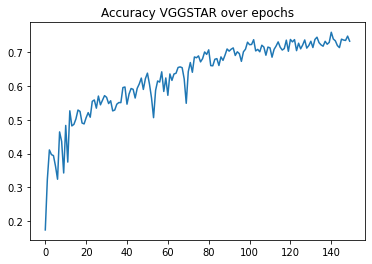

In [14]:
DO = 'TRAIN'
if (DO=='TRAIN'):
  train(nets, loaders, optimizer, criterion, epochs=150, dev=dev,save_param=True)
else:
  state_dicts = torch.load('model.pth')
  model1.load_state_dict(state_dicts['vgg_a']) #questi state_dict vengono dalla funzione di training
  model2.load_state_dict(state_dicts['vgg_b'])
  model3.load_state_dict(state_dicts['vgg_star'])
  classifier.load_state_dict(state_dicts['classifier'])

  test(model1,classifier,test_loader_all)
  test(model2, classifier, test_loader_all)
  test(model3, classifier, test_loader_all)

  summed_state_dict = OrderedDict()

  for key in state_dicts['vgg_star']:
    if key.find('conv') >=0:
      print(key)
      summed_state_dict[key] = combo_fn(state_dicts['vgg_a'][key],state_dicts['vgg_b'][key])
    else:
      summed_state_dict[key] = state_dicts['vgg_star'][key]

  model3.load_state_dict(summed_state_dict)
  test(model3, classifier, test_loader_all)